Universe size: 48  |  Ranked tickers: 48
Last session: 2025-10-21 vs prev 2025-10-20

Top gainers:
ticker      ret   zscore  price_prev  price_last
  ADBE 0.041206 2.195642  343.399994  357.549988
    KO 0.040620 3.498587   68.440002   71.220001
   CRM 0.035905 1.502935  254.279999  263.410004
  AMZN 0.025637 1.557574  216.479996  222.029999
   MRK 0.015060 0.593659   86.320000   87.620003
   UPS 0.013232 1.081269   86.910004   88.059998
    GE 0.013050 1.060384  302.679993  306.630005
   NKE 0.010943 0.449667   67.620003   68.360001
  QCOM 0.010716 0.436931  167.039993  168.830002
    MA 0.010011 0.923565  566.359985  572.030029

Top losers:
ticker       ret    zscore  price_prev  price_last
 GOOGL -0.023738 -1.581361  256.549988  250.460007
  AVGO -0.018841 -0.626374  349.239990  342.660004
   JPM -0.017430 -1.392722  302.359985  297.089996
   WFC -0.014648 -0.618017   86.019997   84.760002
   CAT -0.012293 -0.678783  531.179993  524.650024
    VZ -0.012255 -0.862157   40.799999   40

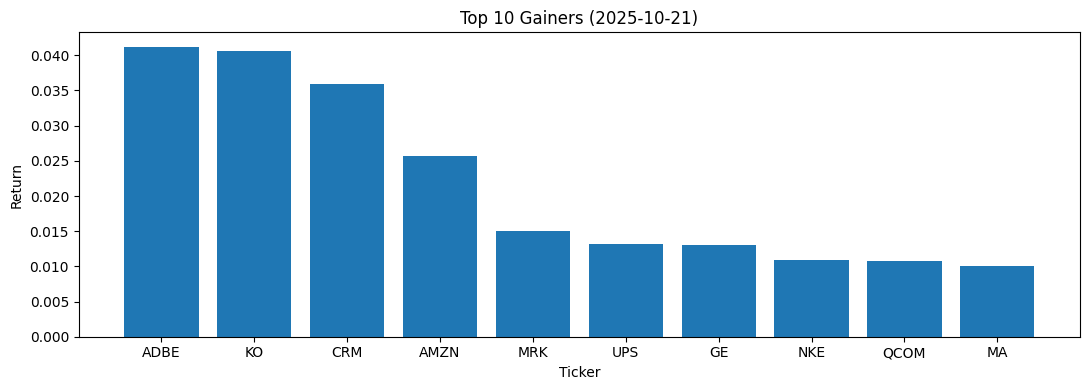

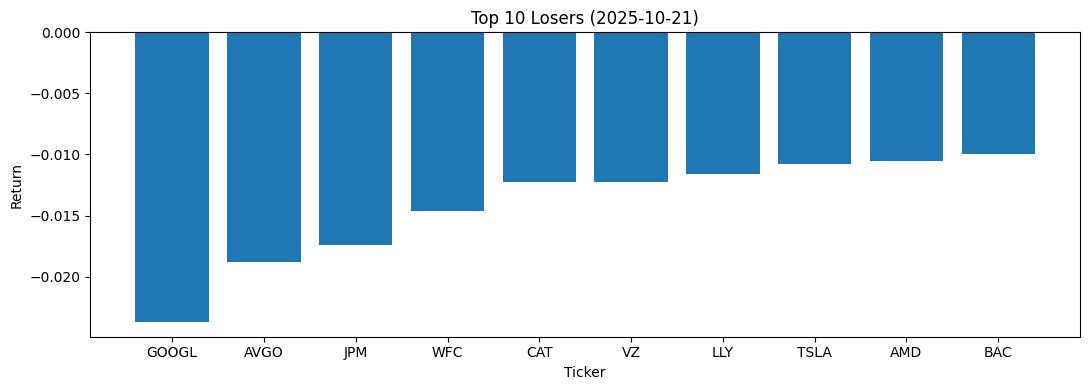

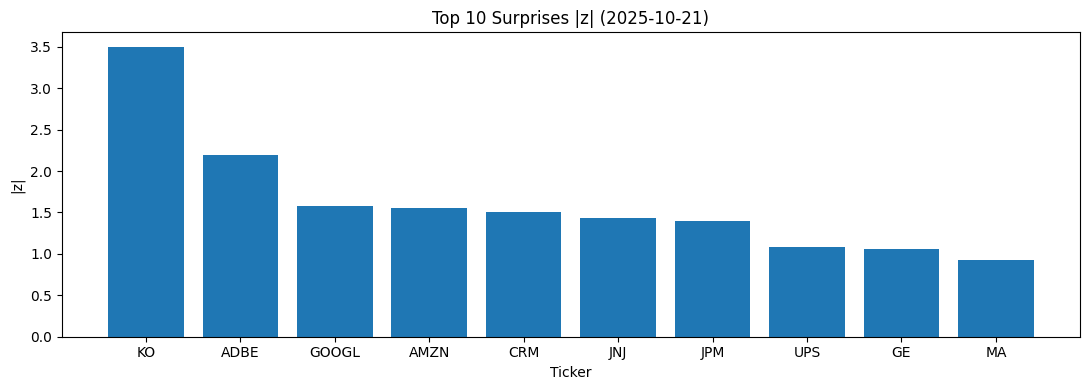

In [1]:
# Step 23 — Heaps + Top-N Movers (one cell, hardened)
# Finds top N gainers, losers, and surprises (z-score of return) using heaps.

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import heapq
from pathlib import Path
from typing import Iterable, Tuple, List, Dict, Optional

# --------------------- User params ---------------------
UNIVERSE: List[str] = [
    # Add more tickers freely; this is just a starter US large-cap set
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","AVGO","BRK-B","JPM",
    "V","XOM","LLY","UNH","WMT","MA","PG","HD","COST","JNJ","NFLX","PEP",
    "BAC","KO","ABBV","PFE","MRK","CSCO","CRM","ADBE","AMD","QCOM","INTC",
    "AMAT","ORCL","NKE","MCD","WFC","T","VZ","IBM","GE","UPS","CAT","BA",
    "SPY","QQQ","IWM"
]
N_TOP: int = 10      # Top N to report
VOL_WINDOW: int = 20 # days for volatility
LOOKBACK_YEARS: int = 2
OUT_DIR = Path(r"C:\Users\adity\Downloads\Learn_DSA_Quant\Level-23")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --------------------- Helpers ---------------------
def to_1d(a): return np.asarray(a, dtype=float).reshape(-1)

def download_close(tickers: List[str], years: int = 2) -> pd.DataFrame:
    """Download daily adjusted close for tickers (auto_adjust=True) with sensible fallbacks."""
    try:
        df = yf.download(" ".join(tickers), period=f"{years}y", interval="1d",
                         auto_adjust=True, progress=False, threads=True)
        if df.empty:
            return pd.DataFrame()
        if isinstance(df.columns, pd.MultiIndex):
            if "Close" in df.columns.get_level_values(0):
                px = df["Close"].copy()
            else:
                # Fallback: take last level group
                lvl0 = df.columns.get_level_values(0)
                px = df[lvl0.unique()[-1]].copy()
        else:
            # Single ticker -> ensure a DataFrame with the ticker name
            if "Close" in df.columns:
                px = df[["Close"]].copy()
                # If only one ticker passed, name the column with it
                if len(tickers) == 1:
                    px.columns = [tickers[0]]
            else:
                # Fallback: if "Adj Close" exists after auto_adjust=False (shouldn't happen), try it
                px = df[["Adj Close"]].copy()
                if len(tickers) == 1:
                    px.columns = [tickers[0]]
        px = px.dropna(how="all").ffill().dropna(how="any")
        return px
    except Exception:
        return pd.DataFrame()

def make_synthetic(tickers: List[str], years=2, seed=23) -> pd.DataFrame:
    """Make synthetic geometric Brownian motion prices as a fallback."""
    np.random.seed(seed)
    n = years*252
    dates = pd.bdate_range(end=pd.Timestamp.today().normalize(), periods=n)
    data = {}
    for t in tickers:
        mu = 0.10 + 0.05*np.random.randn()
        vol = 0.28 + 0.06*np.random.randn()
        dt = 1/252
        ret = (mu - 0.5*vol**2)*dt + vol*np.sqrt(dt)*np.random.randn(n)
        data[t] = 100*np.exp(np.cumsum(ret))
    return pd.DataFrame(data, index=dates)

def top_k_streaming(items: Iterable[Tuple[float, str]], k: int) -> List[Tuple[float, str]]:
    """
    Streaming min-heap of size k for top-k by score.
    items yields (score, key). Returns list sorted desc by score.
    """
    heap: List[Tuple[float, str]] = []
    for score, key in items:
        if len(heap) < k:
            heapq.heappush(heap, (score, key))  # small scores rise to top (min-heap)
        else:
            # If this score is larger than the smallest in heap, replace it
            if score > heap[0][0]:
                heapq.heapreplace(heap, (score, key))
    # Return sorted descending by score
    return sorted(heap, key=lambda x: x[0], reverse=True)

# --------------------- Data ---------------------
px = download_close(UNIVERSE, LOOKBACK_YEARS)
if px.empty:
    px = make_synthetic(UNIVERSE, LOOKBACK_YEARS)

# Align/clean
px = px.sort_index().loc[:, sorted([c for c in px.columns if pd.api.types.is_number(px[c].dropna().head(1).values[0])])].dropna(how="any")

# Compute one-day returns and vol
ret = px.pct_change()
last_day = ret.index[-1]
prev_day = ret.index[-2]

# If some tickers are NaN on last day (corporate action), drop them from that day
last_ret = ret.loc[last_day].dropna()
# For z-score, use rolling std; align to last day and drop NaN
roll_vol = ret.rolling(VOL_WINDOW).std()
last_vol = roll_vol.loc[last_day].reindex(last_ret.index).dropna()

# Common set for fair ranking
common = last_ret.index.intersection(last_vol.index)
last_ret = last_ret.loc[common]
last_vol = last_vol.loc[common]

# Surprise (z) — handle zero vol safely
eps = 1e-12
z = last_ret / np.maximum(last_vol, eps)

# --------------------- Heaps (three views) ---------------------
# 1) Top gainers by return
gainers = heapq.nlargest(N_TOP, ((float(last_ret[t]), t) for t in last_ret.index), key=lambda x: x[0])

# 2) Top losers by return
losers  = heapq.nsmallest(N_TOP, ((float(last_ret[t]), t) for t in last_ret.index), key=lambda x: x[0])

# 3) Top surprises by absolute z-score (streaming heap demo)
surprise_items = ((float(abs(z[t])), t) for t in z.index)
surprises = top_k_streaming(surprise_items, N_TOP)  # returns (|z|, ticker) desc

# Build tidy tables
def build_table(pairs: List[Tuple[float,str]], label: str) -> pd.DataFrame:
    rows = []
    for score, t in pairs:
        rows.append({
            "ticker": t,
            "score": float(score),
            "ret": float(last_ret.get(t, np.nan)),
            "zscore": float(z.get(t, np.nan)),
            "price_prev": float(px[t].loc[prev_day]),
            "price_last": float(px[t].loc[last_day]),
        })
    out = pd.DataFrame(rows)
    out["rank_type"] = label
    # nicer sorting per label
    if label == "gainers": out = out.sort_values("ret", ascending=False)
    elif label == "losers": out = out.sort_values("ret", ascending=True)
    else: out = out.sort_values("score", ascending=False)
    return out.reset_index(drop=True)

tbl_gainers   = build_table(gainers,   "gainers")
tbl_losers    = build_table(losers,    "losers")
tbl_surprises = build_table(surprises, "surprises(|z|)")

# Combine and save
combined = pd.concat([tbl_gainers, tbl_losers, tbl_surprises], axis=0, ignore_index=True)
out_csv = OUT_DIR / "top_movers_last_session.csv"
combined.to_csv(out_csv, index=False)

print(f"Universe size: {len(UNIVERSE)}  |  Ranked tickers: {len(common)}")
print(f"Last session: {last_day.date()} vs prev {prev_day.date()}")
print("\nTop gainers:")
print(tbl_gainers[["ticker","ret","zscore","price_prev","price_last"]].to_string(index=False))
print("\nTop losers:")
print(tbl_losers[["ticker","ret","zscore","price_prev","price_last"]].to_string(index=False))
print("\nTop surprises (|z|):")
print(tbl_surprises[["ticker","zscore","ret","price_prev","price_last"]].to_string(index=False))
print(f"\nSaved CSV -> {out_csv}")

# --------------------- Plots ---------------------
def barplot(df: pd.DataFrame, title: str, ycol: str, ylabel: str):
    # Ensure exactly N bars (clip)
    d = df.head(N_TOP)
    x = np.arange(len(d))
    plt.figure(figsize=(11,4))
    plt.bar(d["ticker"], d[ycol])
    plt.title(title)
    plt.xlabel("Ticker"); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()

barplot(tbl_gainers,   f"Top {N_TOP} Gainers ({last_day.date()})", "ret", "Return")
barplot(tbl_losers,    f"Top {N_TOP} Losers ({last_day.date()})",  "ret", "Return")
barplot(tbl_surprises, f"Top {N_TOP} Surprises |z| ({last_day.date()})", "score", "|z|")
